In [1]:
import math
import time 
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import ttest_ind

from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer



In [2]:
housing = pd.read_csv('Melbourne.csv')

In [3]:
housing.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

In [4]:
housing['Date'] = pd.to_datetime(housing['Date'])

In [5]:
housing.fillna(housing.median(), inplace=True)

housing = housing.apply(lambda x:x.fillna(x.value_counts().index[0]))


In [6]:
housing.Bathroom = housing.Bathroom.map(lambda x: x if x>0 else 1)
housing.BuildingArea = housing.BuildingArea.map(lambda x: x if x>0 else None)

In [7]:
housingtotransf = housing.dropna(axis=0,subset=['Regionname', 'CouncilArea', 'Propertycount'])

housingcat = housingtotransf[['Suburb', 'Address', 'Type', 'Method', 'SellerG', 
                     'Date', 'Regionname', 'CouncilArea']]
housingcont = housingtotransf.loc[:,~(housing.columns.isin(housingcat.columns))]

In [8]:
input = Imputer(strategy='median')
housingtransformed = pd.DataFrame(input.fit_transform(housingcont), 
                               columns=[housingcont.columns])

c:\users\ben\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [9]:
housingtransformed.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,3.485700e+04,34857.000000,34857.000000,34857.000000,34857.000000,34857.000000,34857.000000,34857.000000,34857.000000,34857.00000,34857.000000,34857.000000
mean,3.031012,1.010838e+06,11.184904,3116.062484,3.064693,1.714663,1.796741,569.001520,145.859353,1967.898643,-37.80994,145.003212,7572.818602
std,0.969933,5.719992e+05,6.788797,109.022361,0.858090,0.650295,0.882969,2763.907731,252.131263,25.042048,0.07929,0.105558,4427.906124
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,1.000000,0.000000,0.000000,0.010000,1196.000000,-38.19043,144.423790,83.000000
25%,2.000000,6.950000e+05,6.400000,3051.000000,3.000000,1.000000,1.000000,357.000000,136.000000,1970.000000,-37.84690,144.964400,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.000000,1970.000000,-37.80760,145.007800,6763.000000
75%,4.000000,1.150000e+06,14.000000,3156.000000,3.000000,2.000000,2.000000,598.000000,136.000000,1970.000000,-37.77090,145.051750,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.000000,2106.000000,-37.39020,145.526350,21650.000000


In [10]:
housings = [housingtransformed, housingcat]
housingt = pd.concat(housings, axis=1)

print(housingt.columns)

housingt.columns=(['Rooms', 'Price','Distance','Postcode', 'Bedroom2', 'Bathroom','Car',
                'Landsize','BuildingArea','YearBuilt','Latitude',
                'Longitude','Propertycount','Suburb','Address','Type',
               'Method','SellerG','Date','Regionname','CouncilArea'])
housingt.head()

Index([        ('Rooms',),         ('Price',),      ('Distance',),
            ('Postcode',),      ('Bedroom2',),      ('Bathroom',),
                 ('Car',),      ('Landsize',),  ('BuildingArea',),
           ('YearBuilt',),     ('Lattitude',),    ('Longtitude',),
       ('Propertycount',),           'Suburb',          'Address',
                   'Type',           'Method',          'SellerG',
                   'Date',       'Regionname',      'CouncilArea'],
      dtype='object')


,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,...,Longitude,Propertycount,Suburb,Address,Type,Method,SellerG,Date,Regionname,CouncilArea
0,2.0,870000.0,2.5,3067.0,2.0,1.0,1.0,126.0,136.0,1970.0,...,144.9958,4019.0,Abbotsford,68 Studley St,h,SS,Jellis,2016-03-09,Northern Metropolitan,Yarra City Council
1,2.0,1480000.0,2.5,3067.0,2.0,1.0,1.0,202.0,136.0,1970.0,...,144.9984,4019.0,Abbotsford,85 Turner St,h,S,Biggin,2016-03-12,Northern Metropolitan,Yarra City Council
2,2.0,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,...,144.9934,4019.0,Abbotsford,25 Bloomburg St,h,S,Biggin,2016-04-02,Northern Metropolitan,Yarra City Council
3,3.0,870000.0,2.5,3067.0,3.0,2.0,1.0,0.0,136.0,1970.0,...,145.0116,4019.0,Abbotsford,18/659 Victoria St,u,VB,Rounds,2016-04-02,Northern Metropolitan,Yarra City Council
4,3.0,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,...,144.9944,4019.0,Abbotsford,5 Charles St,h,SP,Biggin,2017-04-03,Northern Metropolitan,Yarra City Council


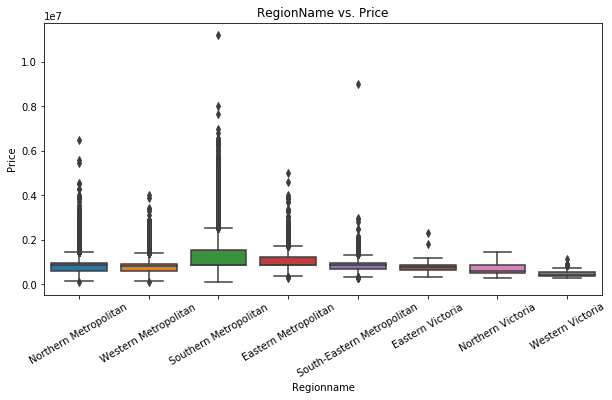

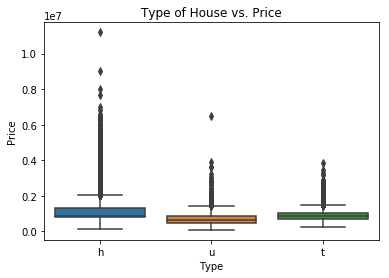

In [11]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Regionname', y='Price', data=housingt)
plt.title('RegionName vs. Price')
plt.xticks(rotation=30)
plt.show()

plt.subplot(1,1,1)
sns.boxplot(x='Type', y='Price', data=housingt)
plt.title('Type of House vs. Price')
plt.show()



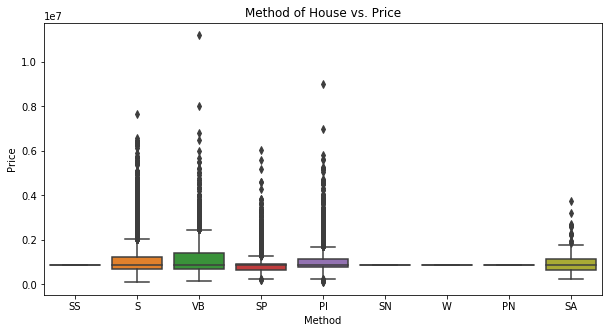

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Method', y='Price', data=housingt)
plt.title('Method of House vs. Price')
plt.show()

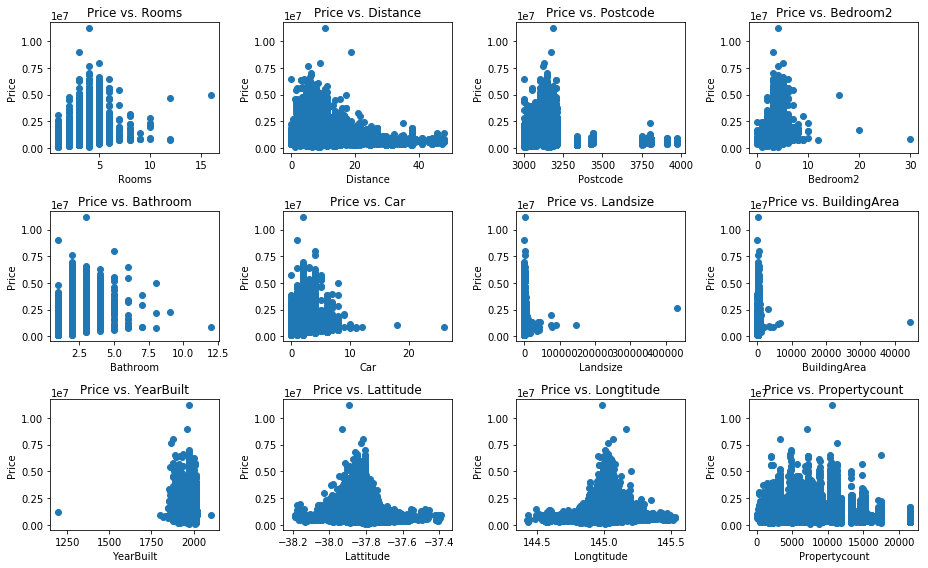

In [13]:
plt.figure(figsize=(13,8))
i=1

for col in housingcont.columns.drop('Price'):
    plt.subplot(3,4,i)
    plt.scatter(x=housingcont[col], y=housingcont['Price'])
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.title('Price vs. {}'.format(col))
    i+=1

plt.tight_layout()
plt.show()

Text(0.5,1,'Variable Correlation')

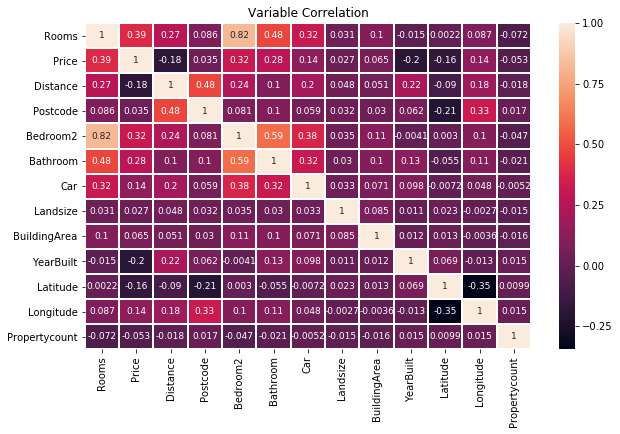

In [14]:
plt.figure(figsize=(10,6))
sns.heatmap(housingt.corr(),linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')

In [15]:
featuresi = housingt[['Price', 'Rooms', 'Car', 'Longitude', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']]

featuresi['Historic'] = np.where(housingt['YearBuilt'] < (2017-60), 1,0)

featuresi = featuresi.dropna()

c:\users\ben\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
X = featuresi.drop('Price', axis=1)
Y = featuresi['Price']

In [17]:
housingeval = pd.DataFrame()
evals = np.zeros(4)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [18]:
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
print('The coefficients are:', linreg.coef_)
print('The intercept is:', linreg.intercept_)

The coefficients are: [ 2.55090479e+05  4.37818239e+04  8.62344639e+05 -2.64171282e+04
  4.96553157e+00  5.93578958e+01 -1.70924060e+03  1.01748554e+05]
The intercept is: -121251114.0381702


In [19]:
scoreslr = cross_val_score(linreg, X_train, Y_train, cv=10)
print('The cross validation scores is: {:.3f} (+/- {:.2f}).'.format(scoreslr.mean(), 
                                                                      (scoreslr.std())*2))

The cross validation scores is: 0.201 (+/- 0.55).


In [20]:
scoreslrT = cross_val_score(linreg, X_test, Y_test, cv=10)
print('The cross validation scores is: {:.3f} (+/- {:.2f}).'.format(scoreslrT.mean(), 
                                                                      (scoreslrT.std())*2))
print('The r-squared for test set is:', linreg.score(X_test, Y_test))

The cross validation scores is: 0.282 (+/- 0.08).
The r-squared for test set is: 0.2870902994075558


In [21]:
start = time.time()
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, Y_train)
print ("The runtime for this dataset is %0.3f." % (time.time() - start))

The runtime for this dataset is 8.992.
